In [28]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

diabetes_data = pd.read_csv('diabetes.csv')
# Data Preparation
X = diabetes_data.drop('Outcome', axis=1).values
y = diabetes_data['Outcome'].values

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Converting to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Adding an extra dimension for LSTM
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Creating data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM Model Definition
class ComplexDiabetesLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=64, output_size=1, num_layers=3, dropout_rate=0.5):
        super(ComplexDiabetesLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # LSTM with multiple layers and dropout
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)

        # Additional Linear layers
        self.linear1 = nn.Linear(hidden_layer_size, 32)
        self.linear2 = nn.Linear(32, output_size)

        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step

        out = self.dropout(self.relu(self.linear1(lstm_out)))
        predictions = torch.sigmoid(self.linear2(out))

        return predictions

# Model, Loss, Optimizer
model = ComplexDiabetesLSTM(input_size=X_train.shape[1])
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training Loop
epochs = 300
for i in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(inputs)

        single_loss = loss_function(y_pred.view(-1), labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# Model Summary
model.eval()
print(model)


epoch:   0 loss: 0.69763511
epoch:  10 loss: 0.54063463
epoch:  20 loss: 0.23854996
epoch:  30 loss: 0.35226461
epoch:  40 loss: 0.35793784
epoch:  50 loss: 1.21748435
epoch:  60 loss: 0.30541667
epoch:  70 loss: 0.35359848
epoch:  80 loss: 0.79272026
epoch:  90 loss: 0.47297454
epoch: 100 loss: 0.12956588
epoch: 110 loss: 0.73675698
epoch: 120 loss: 0.21876459
epoch: 130 loss: 0.43152463
epoch: 140 loss: 0.54911917
epoch: 150 loss: 0.39269805
epoch: 160 loss: 0.13151905
epoch: 170 loss: 1.24093246
epoch: 180 loss: 0.47870770
epoch: 190 loss: 0.25133085
epoch: 200 loss: 0.10622872
epoch: 210 loss: 0.50334918
epoch: 220 loss: 0.14562821
epoch: 230 loss: 0.22426742
epoch: 240 loss: 0.08275504
epoch: 250 loss: 0.17005210
epoch: 260 loss: 0.04579890
epoch: 270 loss: 0.11834233
epoch: 280 loss: 0.14114447
epoch: 290 loss: 1.44988430
epoch: 299 loss: 0.4115936756
ComplexDiabetesLSTM(
  (lstm): LSTM(8, 64, num_layers=3, batch_first=True, dropout=0.5)
  (linear1): Linear(in_features=64, out_fe

In [29]:
# Saving the model parameters
torch.save(model.state_dict(), 'diabetes_model.pth')


In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make sure the model is in evaluation mode
model.eval()
device = torch.device("cpu")
# Lists to store actual and predicted values
actuals = []
predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        
        actuals.extend(labels.view(-1).cpu().numpy())
        predictions.extend(torch.round(output.view(-1)).cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions)
recall = recall_score(actuals, predictions)
f1 = f1_score(actuals, predictions)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Accuracy: 0.7208, Precision: 0.6034, Recall: 0.6364, F1 Score: 0.6195


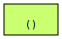

In [31]:
import torch
from torchviz import make_dot

# Ensure the ComplexDiabetesLSTM class is defined here

# Assuming the input size is known and correctly set
input_size = 8
# Initialize the model
model = ComplexDiabetesLSTM(input_size)

# Define the device and move the model to the chosen device
device = torch.device("cpu")
model.to(device)

# Load the saved model state
model.load_state_dict(torch.load('diabetes_model.pth', map_location=device))

# Create a sample input tensor
sample_input = torch.randn(1, 1, input_size).to(device)

# Forward pass
model.eval()
with torch.no_grad():
    y = model(sample_input)

# Visualize the computational graph
dot = make_dot(y.mean(), params=dict(model.named_parameters()))

# If using a Jupyter Notebook, this will display the graph
dot
